Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from numba import jit
import os
from pathlib import Path
from skimage.io import imread, imshow
import random

Scan the image folder

In [67]:
df = pd.DataFrame()
datasetPath = Path('image.orig')
patharr = [ os.path.join(datasetPath, f) for f in os.listdir(datasetPath) if os.path.isdir(os.path.join(datasetPath, f))]
for dirpath in patharr:
    category = dirpath.split("\\")[1]
    df1 = pd.DataFrame()
    df1['image'] = [ os.path.join(dirpath, f) for f in os.listdir(dirpath) if os.path.isfile(os.path.join(dirpath, f))]
    df1['imgcategory'] = [ category for i in range(0, len(df1['image']))]
    df = df.append(df1)
    del df1
df.head()

,image,imgcategory
0,image.orig\african\0.jpg,african
1,image.orig\african\1.jpg,african
2,image.orig\african\10.jpg,african
3,image.orig\african\100.jpg,african
4,image.orig\african\11.jpg,african


Functions for extracting hsv histogram

In [68]:
@jit(nopython=True)
def rgb_to_hsv(r, g, b):
	r, g, b = r / 255.0, g / 255.0, b / 255.0
	cmax = max(r, g, b) 
	cmin = min(r, g, b) 
	diff = cmax-cmin	
	if cmax == cmin:
		h = 0
	elif cmax == r:
		h = (60 * ((g - b) / diff) + 360) % 360
	elif cmax == g:
		h = (60 * ((b - r) / diff) + 120) % 360
	elif cmax == b:
		h = (60 * ((r - g) / diff) + 240) % 360
	if cmax == 0:
		s = 0
	else:
		s = (diff / cmax) * 100
	v = cmax * 100
	return h, s, v


In [69]:
@jit(nopython=True)
def extract_features(image):
    colhist = np.zeros(256) 
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            r = image[i][j][0]
            g = image[i][j][1]
            b = image[i][j][2]
            h, s, v = rgb_to_hsv(r, g, b)
            bin_items(h, s, v, colhist)
    return colhist

In [70]:
@jit(nopython=True)
def bin_items(h, s, v, colhist):
    index = 0
    crrh = 0
    for i in range(1, 17):
        crrh = crrh + 22.5
        index += 16
        if(crrh > h):
            break
    index -= 16
    crrh = 0
    for i in range(1, 5):
        crrh = crrh + 25
        index += 4
        if(crrh > s):
            break
    index -= 4
    crrh = 0
    for i in range(1, 5):
        crrh = crrh + 25
        index += 1
        if(crrh > v):
            break
    index -= 1
    colhist[index] += 1


In [71]:
def getimagefeatures():
    database_features = np.empty([len(df['image']), 256])
    index = 0
    for imgpath in df['image']:
        image = imread(imgpath)
        image_features = extract_features(image)
        database_features[index] = image_features
        index += 1
        if(index%1000 == 0):
            print(index);
    return database_features

imgfeatures = getimagefeatures();

1000


In [79]:
numimages = 29
def match_image(randomimage, image_cat, mode='noshow'):
    if(mode=='show'):
        axes=[]
        fig=plt.figure(figsize=(8,8))
    query_features = extract_features(randomimage)
    distancevector = np.empty([len(df['image'])])
    for i in range(0, len(df['image'])):
        image_features = imgfeatures[i]
        distancevector[i] = np.linalg.norm(image_features - query_features, axis=0)
    indexes = np.arange(distancevector.shape[0])
    dis_frame = pd.DataFrame({'Distance': distancevector, 'Index': indexes})
    dis_frame = dis_frame.reset_index(drop=True)
    dis_frame = dis_frame.sort_values('Distance', ascending=True)
    index = 0
    correct = 0
    for item in dis_frame.itertuples(index=True, name='Pandas'):
        if(index >= numimages):
            break
        img_index = item.Index
        if(df.iloc[img_index].imgcategory == image_cat):
            correct += 1
        if(index < 18 and mode=='show'):
            image = imread(df.iloc[item.Index].image)
            axes.append(fig.add_subplot(5, 6, index+1))
            plt.axis('off')
            plt.imshow(image)
        index+=1
    print('Accuracy with hsv_histogram and euclidian distance - ', (correct/numimages)*100, '%')
    if(mode=='show'):
        fig.tight_layout()
        plt.show()
    print(correct)
    return (correct/numimages)*100

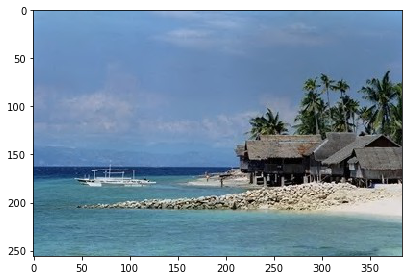

In [112]:
image_name = 'image.orig\\beach\\192.jpg'
image_cat = 'beach'
image = imread(image_name)
imshow(image)

Accuracy with hsv_histogram and euclidian distance -  31.03448275862069 %


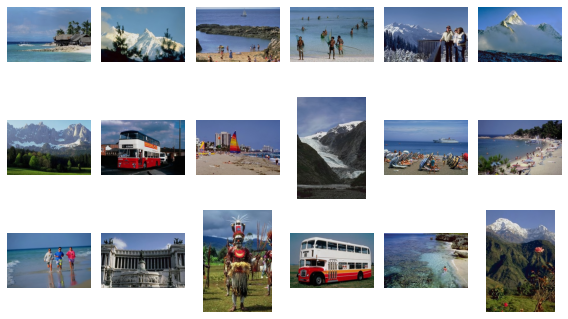

9


31.03448275862069

In [113]:
match_image(image, image_cat, mode='show')

In [147]:
img_count = 10
crr = 0
for i in range(0,img_count):
    randomIndex = random.randint(0, len(df))
    randomimage = df.iloc[randomIndex].image
    print(randomimage)
    image = imread(randomimage)
    image_cat = df.iloc[randomIndex].imgcategory
    crr += match_image(image, image_cat)
print("Average accuracy for " + str(img_count) + " images is - " + str(crr/img_count) + " %")

image.orig\horse\763.jpg
Accuracy with hsv_histogram and euclidian distance -  100.0 %
29
image.orig\bus\306.jpg
Accuracy with hsv_histogram and euclidian distance -  93.10344827586206 %
27
image.orig\bus\341.jpg
Accuracy with hsv_histogram and euclidian distance -  72.41379310344827 %
21
image.orig\mountain\987.jpg
Accuracy with hsv_histogram and euclidian distance -  34.48275862068966 %
10
image.orig\mountain\948.jpg
Accuracy with hsv_histogram and euclidian distance -  62.06896551724138 %
18
image.orig\building\254.jpg
Accuracy with hsv_histogram and euclidian distance -  48.275862068965516 %
14
image.orig\african\45.jpg
Accuracy with hsv_histogram and euclidian distance -  82.75862068965517 %
24
image.orig\elephant\519.jpg
Accuracy with hsv_histogram and euclidian distance -  44.827586206896555 %
13
image.orig\dinosaur\413.jpg
Accuracy with hsv_histogram and euclidian distance -  100.0 %
29
image.orig\flower\671.jpg
Accuracy with hsv_histogram and euclidian distance -  86.206896551

Extracting features for Kmeans

In [140]:
image_data = pd.DataFrame(imgfeatures)
kmeans = KMeans(init="random", n_clusters=15, max_iter=600, random_state=42)
kmeans.fit(image_data)
df['cluster'] = kmeans.labels_.tolist()

In [141]:
numimages = 29
def match_image2(image_name, image_cat, mode='noshow'):
    index = 0
    correct = 0
    if(mode=='show'):
        axes=[]
        fig=plt.figure(figsize=(8,8))
    image_index = list(np.where(df['image'] == image_name)[0])[0]
    cluster_no = df.iloc[image_index].cluster
    outoff = 0
    for item in df.itertuples(index=True, name='Pandas'):
        if(index >= numimages):
            break
        if(item.cluster == cluster_no):
            outoff += 1
            if(item.imgcategory == image_cat):
                correct += 1
            if(index < 18 and mode=='show'):
                image = imread(item.image)
                axes.append(fig.add_subplot(5, 6, index+1))
                plt.axis('off')
                plt.imshow(image)
            index+=1
    print('Accuracy with hsv_histogram and Kmeans - ', (correct/numimages)*100, ' % out off - ', outoff)
    if(mode=='show'):
        fig.tight_layout()
        plt.show()
    return (correct/numimages)*100


Accuracy with hsv_histogram and Kmeans -  0.0  % out off -  29


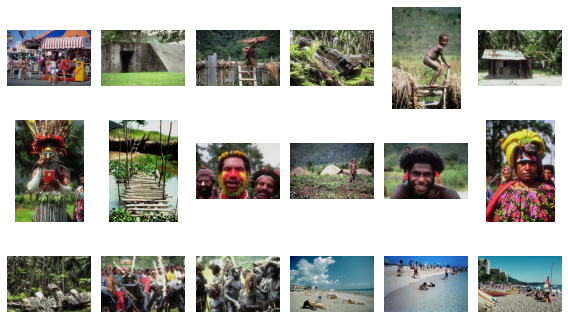

0.0

In [145]:
image_name = 'image.orig\\food\\859.jpg'
image_cat = 'food'
match_image2(image_name, image_cat, mode='show')

In [144]:
img_count = 10
crr = 0
for i in range(0,img_count):
    randomIndex = random.randint(0, len(df))
    randomimage = df.iloc[randomIndex].image
    image_cat = df.iloc[randomIndex].imgcategory
    print(randomimage, image_cat)
    crr += match_image2(randomimage, image_cat)
print("Average accuracy for " + str(img_count) + " images is - " + str(crr/img_count) + " %")

image.orig\horse\788.jpg horse
Accuracy with hsv_histogram and Kmeans -  62.06896551724138  % out off -  29
image.orig\building\246.jpg building
Accuracy with hsv_histogram and Kmeans -  0.0  % out off -  29
image.orig\dinosaur\436.jpg dinosaur
Accuracy with hsv_histogram and Kmeans -  100.0  % out off -  29
image.orig\bus\372.jpg bus
Accuracy with hsv_histogram and Kmeans -  41.37931034482759  % out off -  29
image.orig\dinosaur\426.jpg dinosaur
Accuracy with hsv_histogram and Kmeans -  96.55172413793103  % out off -  29
image.orig\bus\395.jpg bus
Accuracy with hsv_histogram and Kmeans -  0.0  % out off -  29
image.orig\food\859.jpg food
Accuracy with hsv_histogram and Kmeans -  0.0  % out off -  29
image.orig\bus\353.jpg bus
Accuracy with hsv_histogram and Kmeans -  0.0  % out off -  29
image.orig\flower\626.jpg flower
Accuracy with hsv_histogram and Kmeans -  58.620689655172406  % out off -  29
image.orig\flower\648.jpg flower
Accuracy with hsv_histogram and Kmeans -  93.10344827586